# Quantization + Rate-Distortion (Llama Weights)

**Objective:** Explore weight-only quantization for Llama models and measure empirical rate-distortion curves vs the Shannon bound.

**Bound (Gaussian):**  
R(D) = 1/2 * log2(sigma^2 / D) for D <= sigma^2

This notebook combines:
- Weight extraction (MLP + attention + embeddings)
- Quantization sweeps (per-tensor vs per-channel)
- Rate-distortion comparisons (uniform, clipped, Lloyd-Max, group)
- Vector quantization (k-means, d = 2, 4, 8)
- Product quantization (multi-codebook variant)


In [ ]:
# === AUTHENTICATION (required) ===
from huggingface_hub import login

# Paste your token directly as a string argument
login(token="...")

# After running successfully, DELETE this cell or clear the token string

In [2]:
# === Install dependencies ===
# Uncomment the lines below to install required packages

%pip install -q torch torchvision
%pip install -q numpy scipy scikit-learn matplotlib pandas transformers accelerate

In [4]:
!nvidia-smi

Mon Jan 26 18:56:02 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Initial Quantization Experiments
I did this just to get a sense of how to quantize weights in transformers for trivial methods.

In [ ]:
# Core imports
import math
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM

try:
    from sklearn.cluster import MiniBatchKMeans
    SKLEARN_OK = True
except Exception:
    SKLEARN_OK = False

try:
    from scipy.cluster.vq import kmeans, vq
    SCIPY_VQ_OK = True
except Exception:
    SCIPY_VQ_OK = False


In [12]:
# Load model (Llama 3.2 1B by default)
model_name = "meta-llama/Llama-3.2-1B"
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float32,
    device_map="auto",
)
model.eval()

print(f"Loaded: {model_name}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

Loaded: meta-llama/Llama-3.2-1B
Parameters: 1,235,814,400


In [ ]:
# Extract weight groups (MLP, attention, embeddings)

def extract_weight_groups(model):
    mlp = {}
    attn = {"q": {}, "k": {}, "v": {}, "o": {}}

    for name, param in model.named_parameters():
        if not name.endswith(".weight"):
            continue
        if "model.layers." not in name:
            continue

        parts = name.split(".")
        try:
            layer_num = int(parts[2])
        except Exception:
            continue

        w = param.detach().cpu().float().numpy()

        if "mlp.down_proj.weight" in name:
            mlp[layer_num] = w
        elif "self_attn.q_proj.weight" in name:
            attn["q"][layer_num] = w
        elif "self_attn.k_proj.weight" in name:
            attn["k"][layer_num] = w
        elif "self_attn.v_proj.weight" in name:
            attn["v"][layer_num] = w
        elif "self_attn.o_proj.weight" in name:
            attn["o"][layer_num] = w

    embeddings = {}
    try:
        embeddings["token"] = model.get_input_embeddings().weight.detach().cpu().float().numpy()
    except Exception:
        pass

    if hasattr(model, "lm_head") and model.lm_head is not None:
        try:
            embeddings["lm_head"] = model.lm_head.weight.detach().cpu().float().numpy()
        except Exception:
            pass

    return mlp, attn, embeddings

mlp_weights, attn_weights, embedding_weights = extract_weight_groups(model)

print(f"MLP down-proj layers: {len(mlp_weights)}")
print("Attention proj layers:")
for k in ["q", "k", "v", "o"]:
    print(f"  {k}: {len(attn_weights[k])}")
print("Embeddings:", list(embedding_weights.keys()))


MLP down-proj layers: 16
Attention proj layers:
  q: 16
  k: 16
  v: 16
  o: 16
Embeddings: ['token', 'lm_head']


In [ ]:
# Quantization utilities (per-tensor vs per-channel)

def symmetric_quantize(x, bits, per_channel=False, axis=1):
    """
    Symmetric uniform quantization to signed integers.
    per_channel=True uses per-output-channel scaling (axis=1 for [out, in]).
    Returns dequantized array and scale(s).
    """
    x = x.astype(np.float32)
    qmax = (2 ** (bits - 1)) - 1

    if per_channel:
        max_abs = np.max(np.abs(x), axis=axis, keepdims=True) + 1e-12
        scale = max_abs / qmax
        q = np.clip(np.round(x / scale), -qmax, qmax)
        dq = q * scale
    else:
        max_abs = float(np.max(np.abs(x)))
        scale = max_abs / qmax if max_abs > 0 else 1.0
        q = np.clip(np.round(x / scale), -qmax, qmax)
        dq = q * scale

    return dq.astype(np.float32), scale


def quant_metrics(x, xq):
    x = x.astype(np.float32)
    xq = xq.astype(np.float32)
    mse = float(np.mean((x - xq) ** 2))
    denom = float(np.mean(x ** 2))
    sqnr_db = 10 * math.log10(denom / mse) if mse > 0 and denom > 0 else float("inf")
    max_abs = float(np.max(np.abs(x)))
    max_err = float(np.max(np.abs(x - xq)))
    return {
        "mse": mse,
        "sqnr_db": sqnr_db,
        "max_abs": max_abs,
        "max_err": max_err,
        "rel_max_err": max_err / max_abs if max_abs > 0 else 0.0,
    }


Layer 8 quantization summary
  Bits       MSE(t)       MSE(c)    SQNR(t)    SQNR(c)
------------------------------------------------------------
     2     2.61e-04     2.34e-04       0.00       0.48
     3     2.60e-04     5.67e-05       0.02       6.63
     4     2.44e-04     1.17e-05       0.30      13.48
     5     1.15e-04     2.61e-06       3.55      20.00
     6     2.93e-05     6.13e-07       9.49      26.29
     8     1.75e-06     3.65e-08      21.73      38.54


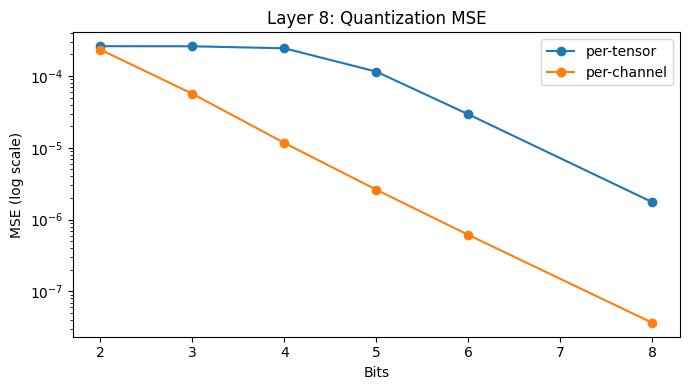

In [ ]:
# Quick bit sweep (per-tensor vs per-channel)
layer = 8
W = mlp_weights[layer]

bits_list = [2, 3, 4, 5, 6, 8]

results = {"per_tensor": [], "per_channel": []}

for bits in bits_list:
    dq_t, _ = symmetric_quantize(W, bits, per_channel=False)
    dq_c, _ = symmetric_quantize(W, bits, per_channel=True, axis=1)

    results["per_tensor"].append(quant_metrics(W, dq_t))
    results["per_channel"].append(quant_metrics(W, dq_c))

print(f"Layer {layer} quantization summary")
print(f"{'Bits':>6} {'MSE(t)':>12} {'MSE(c)':>12} {'SQNR(t)':>10} {'SQNR(c)':>10}")
print("-" * 60)
for i, bits in enumerate(bits_list):
    mt = results["per_tensor"][i]
    mc = results["per_channel"][i]
    print(f"{bits:>6} {mt['mse']:>12.2e} {mc['mse']:>12.2e} {mt['sqnr_db']:>10.2f} {mc['sqnr_db']:>10.2f}")

plt.figure(figsize=(7, 4))
plt.plot(bits_list, [r['mse'] for r in results["per_tensor"]], marker='o', label='per-tensor')
plt.plot(bits_list, [r['mse'] for r in results["per_channel"]], marker='o', label='per-channel')
plt.yscale('log')
plt.xlabel('Bits')
plt.ylabel('MSE (log scale)')
plt.title(f'Layer {layer}: Quantization MSE')
plt.legend()
plt.tight_layout()
plt.show()


Top 8 worst MLP layers at 4-bit per-channel
 Layer          MSE   SQNR(dB)  RelMaxErr
----------------------------------------------
    15     1.36e-05      13.69      0.071
    10     1.22e-05      13.67      0.071
     8     1.17e-05      13.48      0.071
     9     1.17e-05      13.71      0.071
     1     1.16e-05      14.07      0.071
     5     1.16e-05      13.44      0.071
     0     1.14e-05      14.23      0.071
    14     1.13e-05      14.47      0.071


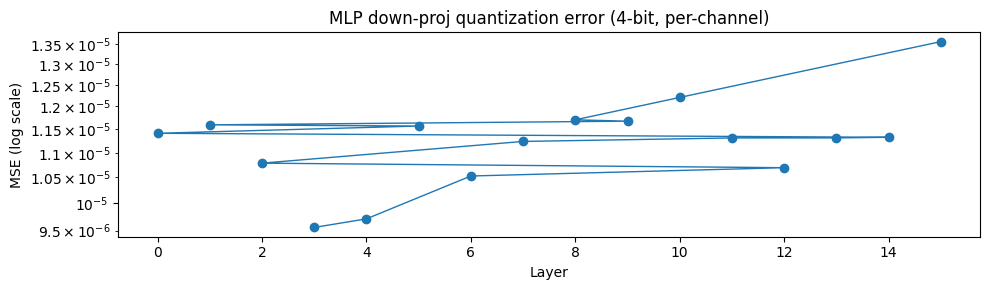

In [ ]:
# Layerwise sensitivity at a fixed bit-width (per-channel)
bits = 4

layer_rows = []
for layer_num, W in sorted(mlp_weights.items()):
    dq, _ = symmetric_quantize(W, bits, per_channel=True, axis=1)
    m = quant_metrics(W, dq)
    layer_rows.append((layer_num, m["mse"], m["sqnr_db"], m["rel_max_err"]))

layer_rows.sort(key=lambda t: t[1], reverse=True)

print(f"Top 8 worst MLP layers at {bits}-bit per-channel")
print(f"{'Layer':>6} {'MSE':>12} {'SQNR(dB)':>10} {'RelMaxErr':>10}")
print("-" * 46)
for layer_num, mse, sqnr_db, rel_max_err in layer_rows[:8]:
    print(f"{layer_num:>6} {mse:>12.2e} {sqnr_db:>10.2f} {rel_max_err:>10.3f}")

layers = [r[0] for r in layer_rows]
mse_vals = [r[1] for r in layer_rows]

plt.figure(figsize=(10, 3))
plt.plot(layers, mse_vals, marker='o', linewidth=1)
plt.yscale('log')
plt.xlabel('Layer')
plt.ylabel('MSE (log scale)')
plt.title(f'MLP down-proj quantization error ({bits}-bit, per-channel)')
plt.tight_layout()
plt.show()


In [ ]:
# Shannon bound and gap utilities

def shannon_distortion(sigma_sq, rate_bits):
    return sigma_sq / (4 ** rate_bits)


def gap_bits(mse, d_shannon):
    if mse <= 0 or d_shannon <= 0:
        return 0.0
    return 0.5 * math.log2(mse / d_shannon)


def interpolate_rate_for_distortion(rates, mses, target_d):
    """
    Estimate R(D) by linear interpolation in log-D space.
    rates: list of bits/weight
    mses: list of distortions
    target_d: target distortion
    """
    rates = np.asarray(rates, dtype=np.float32)
    mses = np.asarray(mses, dtype=np.float32)

    if target_d <= 0:
        return None

    order = np.argsort(rates)
    rates = rates[order]
    mses = mses[order]

    logd = np.log(mses + 1e-30)
    logt = np.log(target_d)

    for i in range(len(rates) - 1):
        if (logd[i] >= logt and logd[i + 1] <= logt) or (logd[i] <= logt and logd[i + 1] >= logt):
            t = (logt - logd[i]) / (logd[i + 1] - logd[i] + 1e-30)
            return float(rates[i] + t * (rates[i + 1] - rates[i]))

    return None


In [ ]:
# Scalar + group quantization methods

def quantize_uniform_asymmetric(weights, bits):
    flat = weights.flatten().astype(np.float32)
    levels = 2 ** bits
    w_min, w_max = float(flat.min()), float(flat.max())
    if w_max == w_min:
        return flat, 0.0
    scale = (w_max - w_min) / (levels - 1)
    quantized = np.round((flat - w_min) / scale) * scale + w_min
    mse = float(np.mean((flat - quantized) ** 2))
    return quantized, mse


def quantize_uniform_symmetric(weights, bits):
    flat = weights.flatten().astype(np.float32)
    levels = 2 ** bits
    max_abs = float(np.max(np.abs(flat)))
    if max_abs == 0:
        return flat, 0.0
    scale = (2 * max_abs) / (levels - 1)
    quantized = np.round(flat / scale) * scale
    mse = float(np.mean((flat - quantized) ** 2))
    return quantized, mse


def quantize_symmetric_clipped(weights, bits, clip_sigma=3.0):
    flat = weights.flatten().astype(np.float32)
    levels = 2 ** bits

    mu, sigma = float(np.mean(flat)), float(np.std(flat))
    clip_val = clip_sigma * sigma
    flat_clipped = np.clip(flat, -clip_val, clip_val)

    max_abs = float(np.max(np.abs(flat_clipped)))
    if max_abs == 0:
        return flat, 0.0

    scale = (2 * max_abs) / (levels - 1)
    quantized = np.round(flat_clipped / scale) * scale
    mse = float(np.mean((flat - quantized) ** 2))
    return quantized, mse


def quantize_group(weights, bits, group_size=128):
    flat = weights.flatten().astype(np.float32)
    n = len(flat)

    pad_size = (group_size - n % group_size) % group_size
    if pad_size > 0:
        flat_padded = np.concatenate([flat, np.zeros(pad_size, dtype=np.float32)])
    else:
        flat_padded = flat

    groups = flat_padded.reshape(-1, group_size)
    levels = 2 ** bits
    quantized_groups = np.zeros_like(groups)

    for i in range(groups.shape[0]):
        group = groups[i]
        max_abs = float(np.max(np.abs(group)))
        if max_abs == 0:
            quantized_groups[i] = group
            continue
        scale = (2 * max_abs) / (levels - 1)
        quantized_groups[i] = np.round(group / scale) * scale

    quantized = quantized_groups.flatten()[:n]
    mse = float(np.mean((flat - quantized) ** 2))
    effective_bits = bits + 16 / group_size  # FP16 scale per group
    return quantized, mse, effective_bits


def quantize_lloyd_max(weights, bits, max_iter=20):  # OPTIMIZED: reduced from 100 to 20
    flat = weights.flatten().astype(np.float32)
    levels = 2 ** bits

    percentiles = np.linspace(0, 100, levels + 2)[1:-1]
    centroids = np.percentile(flat, percentiles)

    for _ in range(max_iter):
        boundaries = (centroids[:-1] + centroids[1:]) / 2
        boundaries = np.concatenate([[-np.inf], boundaries, [np.inf]])
        assignments = np.digitize(flat, boundaries[1:-1])

        new_centroids = np.zeros(levels, dtype=np.float32)
        for i in range(levels):
            mask = assignments == i
            if np.any(mask):
                new_centroids[i] = np.mean(flat[mask])
            else:
                new_centroids[i] = centroids[i]

        if np.allclose(centroids, new_centroids, rtol=1e-6):
            break
        centroids = new_centroids

    boundaries = (centroids[:-1] + centroids[1:]) / 2
    assignments = np.digitize(flat, boundaries)
    assignments = np.clip(assignments, 0, levels - 1)
    quantized = centroids[assignments]

    mse = float(np.mean((flat - quantized) ** 2))
    return quantized, mse

In [ ]:
# k-means helpers (vector + product quantization)

def _kmeans_fit(vectors, n_centroids, seed=0):
    if SKLEARN_OK:
        km = MiniBatchKMeans(
            n_clusters=n_centroids,
            random_state=seed,
            batch_size=4096,
            n_init=3,
            max_iter=50,  # OPTIMIZED: reduced from 100 to 50
        )
        km.fit(vectors)
        return km

    if SCIPY_VQ_OK:
        centroids, _ = kmeans(vectors, n_centroids, iter=20)
        return centroids

    raise RuntimeError("No k-means backend found. Install scikit-learn or scipy.")


def _kmeans_assign(vectors, model_or_centroids):
    if SKLEARN_OK and hasattr(model_or_centroids, "predict"):
        return model_or_centroids.predict(vectors), model_or_centroids.cluster_centers_

    if SCIPY_VQ_OK:
        assignments, _ = vq(vectors, model_or_centroids)
        return assignments, model_or_centroids

    raise RuntimeError("No k-means backend found. Install scikit-learn or scipy.")


def quantize_kmeans_vq(weights, bits, dim=2, sample_vectors=10000, eval_vectors=10000, seed=0):  # OPTIMIZED: reduced from 20000 to 10000
    flat = weights.flatten().astype(np.float32)
    n = len(flat)

    pad_size = (dim - n % dim) % dim
    if pad_size > 0:
        flat_padded = np.concatenate([flat, np.zeros(pad_size, dtype=np.float32)])
    else:
        flat_padded = flat

    vectors = flat_padded.reshape(-1, dim)
    rng = np.random.default_rng(seed)

    if sample_vectors is not None and len(vectors) > sample_vectors:
        idx = rng.choice(len(vectors), size=sample_vectors, replace=False)
        train_vectors = vectors[idx]
    else:
        train_vectors = vectors

    n_centroids = 2 ** bits
    model = _kmeans_fit(train_vectors, n_centroids, seed=seed)

    if eval_vectors is not None and len(vectors) > eval_vectors:
        idx = rng.choice(len(vectors), size=eval_vectors, replace=False)
        eval_vectors_subset = vectors[idx]
    else:
        eval_vectors_subset = vectors

    assignments, centroids = _kmeans_assign(eval_vectors_subset, model)
    quantized_vectors = centroids[assignments]

    mse = float(np.mean((eval_vectors_subset - quantized_vectors) ** 2))
    effective_bits = bits / dim
    return quantized_vectors, mse, effective_bits


def quantize_product_quantization(weights, bits, dim=4, codebooks=4, sample_vectors=10000, eval_vectors=10000, seed=0):  # OPTIMIZED: reduced from 20000 to 10000
    flat = weights.flatten().astype(np.float32)
    n = len(flat)

    pad_size = (dim - n % dim) % dim
    if pad_size > 0:
        flat_padded = np.concatenate([flat, np.zeros(pad_size, dtype=np.float32)])
    else:
        flat_padded = flat

    vectors = flat_padded.reshape(-1, dim)
    rng = np.random.default_rng(seed)

    group_ids = np.arange(len(vectors)) % codebooks

    total_se = 0.0
    total_n = 0

    for g in range(codebooks):
        group_vecs = vectors[group_ids == g]
        if len(group_vecs) == 0:
            continue

        if sample_vectors is not None and len(group_vecs) > sample_vectors:
            idx = rng.choice(len(group_vecs), size=sample_vectors, replace=False)
            train_vecs = group_vecs[idx]
        else:
            train_vecs = group_vecs

        n_centroids = 2 ** bits
        model = _kmeans_fit(train_vecs, n_centroids, seed=seed + g)

        if eval_vectors is not None and len(group_vecs) > eval_vectors:
            idx = rng.choice(len(group_vecs), size=eval_vectors, replace=False)
            eval_vecs = group_vecs[idx]
        else:
            eval_vecs = group_vecs

        assignments, centroids = _kmeans_assign(eval_vecs, model)
        quantized = centroids[assignments]

        total_se += float(np.sum((eval_vecs - quantized) ** 2))
        total_n += eval_vecs.size

    mse = total_se / total_n if total_n > 0 else 0.0
    effective_bits = bits / dim
    return mse, effective_bits

In [ ]:
# Scalar quantizers: rate-distortion curves

def measure_scalar_quantizers(weights, bits_list=range(1, 9)):
    flat = weights.flatten().astype(np.float32)
    sigma_sq = float(np.var(flat))

    results = {
        "bits": [],
        "shannon_d": [],
        "uniform_asym": [],
        "uniform_sym": [],
        "clipped_3sigma": [],
        "group_128": [],
        "group_32": [],
        "lloyd_max": [],
        "group_128_rate": [],
        "group_32_rate": [],
    }

    for bits in bits_list:
        print(f"  Computing {bits}-bit quantization...")
        d_shannon = shannon_distortion(sigma_sq, bits)

        results["bits"].append(bits)
        results["shannon_d"].append(d_shannon)

        _, mse = quantize_uniform_asymmetric(weights, bits)
        results["uniform_asym"].append(mse)

        _, mse = quantize_uniform_symmetric(weights, bits)
        results["uniform_sym"].append(mse)

        _, mse = quantize_symmetric_clipped(weights, bits, clip_sigma=3.0)
        results["clipped_3sigma"].append(mse)

        _, mse, eff = quantize_group(weights, bits, group_size=128)
        results["group_128"].append(mse)
        results["group_128_rate"].append(eff)

        _, mse, eff = quantize_group(weights, bits, group_size=32)
        results["group_32"].append(mse)
        results["group_32_rate"].append(eff)

        _, mse = quantize_lloyd_max(weights, bits)
        results["lloyd_max"].append(mse)

    return results


def plot_rate_distortion_scalar(results, title="Rate-Distortion (Scalar and Group)"):
    plt.figure(figsize=(10, 6))

    bits = np.array(results["bits"], dtype=np.float32)
    plt.semilogy(bits, results["shannon_d"], 'k--', linewidth=2, marker='o', label='Shannon bound')

    methods = [
        ("uniform_asym", "Uniform (naive)", 'red'),
        ("uniform_sym", "Uniform (symmetric)", 'orange'),
        ("clipped_3sigma", "Clipped 3sigma", 'green'),
        ("lloyd_max", "Lloyd-Max", 'cyan'),
    ]

    for key, label, color in methods:
        plt.semilogy(bits, results[key], '-', linewidth=1.5, marker='s', label=label, color=color)

    plt.semilogy(results["group_128_rate"], results["group_128"], '-', linewidth=1.5, marker='^', label='Group g=128', color='blue')
    plt.semilogy(results["group_32_rate"], results["group_32"], '-', linewidth=1.5, marker='^', label='Group g=32', color='purple')

    plt.xlabel('Rate (bits per weight)')
    plt.ylabel('Distortion (MSE)')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper right')
    plt.show()


In [ ]:
# Vector and product quantization helpers

def measure_vector_quantizers(weights, dims=(2, 4, 8), codebook_bits=6):  # OPTIMIZED: default reduced from 8 to 6
    curves = []
    for d in dims:
        print(f"  VQ: dim={d}, codebook_bits={codebook_bits}")
        _, mse, eff_bits = quantize_kmeans_vq(
            weights,
            bits=codebook_bits,
            dim=d,
            sample_vectors=10000,  # OPTIMIZED: reduced from 20000
            eval_vectors=10000,    # OPTIMIZED: reduced from 20000
            seed=0,
        )
        curves.append({
            "label": f"VQ d={d} (codebook {codebook_bits} bits)",
            "rates": [eff_bits],
            "mses": [mse],
        })
    return curves


def measure_product_quantizers(weights, dims=(2, 4, 8), codebook_bits=6, codebooks=4):  # OPTIMIZED: default reduced from 8 to 6
    curves = []
    for d in dims:
        print(f"  PQ: dim={d}, codebook_bits={codebook_bits}, codebooks={codebooks}")
        mse, eff_bits = quantize_product_quantization(
            weights,
            bits=codebook_bits,
            dim=d,
            codebooks=codebooks,
            sample_vectors=10000,  # OPTIMIZED: reduced from 20000
            eval_vectors=10000,    # OPTIMIZED: reduced from 20000
            seed=0,
        )
        curves.append({
            "label": f"PQ d={d} (codebook {codebook_bits} bits, {codebooks} codebooks)",
            "rates": [eff_bits],
            "mses": [mse],
        })
    return curves

In [ ]:
# Rate-distortion analysis for a single layer
layer = 8
weights = mlp_weights[layer]

print(f"Analyzing MLP layer {layer}")
print(f"Shape: {weights.shape}, Total weights: {weights.size:,}")
print(f"Variance: {np.var(weights.astype(np.float32)):.6e}")

# OPTIMIZED: reduced bits_list from range(1,9) to key values [2,3,4,5,6,8]
scalar_results = measure_scalar_quantizers(weights, bits_list=[2, 3, 4, 5, 6, 8])
plot_rate_distortion_scalar(scalar_results, title=f"Rate-Distortion: MLP Layer {layer}")

# OPTIMIZED: reduced codebook_bits from 8 to 6 for faster k-means
vq_curves = measure_vector_quantizers(weights, dims=(2, 4, 8), codebook_bits=6)
pq_curves = measure_product_quantizers(weights, dims=(2, 4, 8), codebook_bits=6, codebooks=4)

Analyzing MLP layer 8
Shape: (2048, 8192), Total weights: 16,777,216
Variance: 2.609423e-04
  Computing 2-bit quantization...
  Computing 3-bit quantization...
  Computing 4-bit quantization...


KeyboardInterrupt: 

In [ ]:
# Overlay vector and product quantization points on scalar curves

plt.figure(figsize=(10, 6))

bits = np.array(scalar_results["bits"], dtype=np.float32)
plt.semilogy(bits, scalar_results["shannon_d"], 'k--', linewidth=2, marker='o', label='Shannon bound')

for key, label, color in [
    ("uniform_sym", "Uniform (symmetric)", 'orange'),
    ("clipped_3sigma", "Clipped 3sigma", 'green'),
    ("lloyd_max", "Lloyd-Max", 'cyan'),
]:
    plt.semilogy(bits, scalar_results[key], '-', linewidth=1.5, marker='s', label=label, color=color)

plt.semilogy(scalar_results["group_128_rate"], scalar_results["group_128"], '-', linewidth=1.5, marker='^', label='Group g=128', color='blue')
plt.semilogy(scalar_results["group_32_rate"], scalar_results["group_32"], '-', linewidth=1.5, marker='^', label='Group g=32', color='purple')

for curve in vq_curves + pq_curves:
    plt.semilogy(curve["rates"], curve["mses"], 'D', markersize=7, label=curve["label"])

plt.xlabel('Rate (bits per weight)')
plt.ylabel('Distortion (MSE)')
plt.title(f"Rate-Distortion (MLP layer {layer})")
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right')
plt.show()


In [ ]:
# Gap at target distortions

sigma_sq = float(np.var(weights.flatten().astype(np.float32)))

targets = [0.001 * sigma_sq, 0.01 * sigma_sq]

print("Target distortions:")
for t in targets:
    print(f"  D = {t:.3e}")

curves = [
    ("Uniform (symmetric)", scalar_results["bits"], scalar_results["uniform_sym"]),
    ("Clipped 3sigma", scalar_results["bits"], scalar_results["clipped_3sigma"]),
    ("Group g=128", scalar_results["group_128_rate"], scalar_results["group_128"]),
    ("Group g=32", scalar_results["group_32_rate"], scalar_results["group_32"]),
    ("Lloyd-Max", scalar_results["bits"], scalar_results["lloyd_max"]),
]

for t in targets:
    print(f"
=== Gap summary at D={t:.3e} ===")
    for label, rates, mses in curves:
        r_emp = interpolate_rate_for_distortion(rates, mses, t)
        if r_emp is None:
            print(f"  {label:<16} : insufficient coverage")
            continue
        r_shannon = 0.5 * math.log2(sigma_sq / t)
        gap = r_emp - r_shannon
        print(f"  {label:<16} : R_emp={r_emp:.2f} bits, gap={gap:.2f} bits")


In [ ]:
# Per-group comparison (MLP vs Attention vs Embeddings)

bits_list = list(range(1, 9))


def select_layers(layer_dict, max_layers=6):
    layers = sorted(layer_dict.keys())
    if len(layers) <= max_layers:
        return layers
    idx = np.linspace(0, len(layers) - 1, max_layers).round().astype(int)
    return [layers[i] for i in idx]


def avg_rd_curve(weights_list, bits_list, quantizer_fn):
    mses = []
    for bits in bits_list:
        layer_mses = []
        for W in weights_list:
            _, mse = quantizer_fn(W, bits)
            layer_mses.append(mse)
        mses.append(float(np.mean(layer_mses)))
    return mses

mlp_layers = select_layers(mlp_weights, max_layers=6)
q_layers = select_layers(attn_weights["q"], max_layers=6)

mlp_list = [mlp_weights[i] for i in mlp_layers]
q_list = [attn_weights["q"][i] for i in q_layers]

mlp_curve = avg_rd_curve(mlp_list, bits_list, quantize_uniform_symmetric)
q_curve = avg_rd_curve(q_list, bits_list, quantize_uniform_symmetric)

emb_curve = None
if "token" in embedding_weights:
    emb_curve = [quantize_uniform_symmetric(embedding_weights["token"], b)[1] for b in bits_list]

plt.figure(figsize=(10, 6))
plt.semilogy(bits_list, mlp_curve, '-o', label=f"MLP down (avg {len(mlp_layers)} layers)")
plt.semilogy(bits_list, q_curve, '-o', label=f"Attention Q (avg {len(q_layers)} layers)")
if emb_curve is not None:
    plt.semilogy(bits_list, emb_curve, '-o', label="Token embeddings")

plt.xlabel('Rate (bits per weight)')
plt.ylabel('Distortion (MSE)')
plt.title('Per-group comparison (uniform symmetric)')
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right')
plt.show()


# Phase 1: State-of-the-Art Comparison

**Objective:** Compare our simple quantization methods against production-grade GPTQ, AWQ, and bitsandbytes to understand the gap.

**Key Questions:**
1. How much better is GPTQ/AWQ (with Hessian-based error compensation) than simple uniform quantization?
2. Does NF4 (Gaussian-optimized) beat FP4 (uniform log-spacing)? This validates our Gaussian assumption.
3. Is weight MSE a good proxy for functional distortion (output MSE)?

**Expected findings:**
- GPTQ/AWQ should achieve ~0.5-1.0 bits better than our simple methods due to error compensation
- NF4 should beat FP4, confirming near-Gaussian weight distributions
- Weight importance should be non-uniform (functional MSE != weight MSE)

## Load Pre-Quantized GPTQ/AWQ Models

Install required libraries and load quantized checkpoints.

In [7]:

# ============================================
# Load Original FP16 Model (already loaded above)
# ============================================
# We'll reuse the 'model' variable from cell 4 as our FP16 baseline

# ============================================
# Load AWQ 4-bit Quantized Model
# ============================================
print("Loading AWQ 4-bit model...")
try:
    # These AWQ checkpoints include pre-quantized weights and load directly with Transformers.
    model_awq = AutoModelForCausalLM.from_pretrained(
        "AMead10/Llama-3.2-1B-Instruct-AWQ",
        torch_dtype=torch.float16,
        device_map="auto",
    )

    print("✓ AWQ model loaded successfully")
    AWQ_AVAILABLE = True

except Exception as e:
    print(f"✗ AWQ model loading failed: {e}")
    print("  Try upgrading transformers or verifying the checkpoint supports HF quantized weights")
    model_awq = None
    AWQ_AVAILABLE = False

# ============================================
# Load GPTQ 4-bit Quantized Model
# ============================================
print("Loading GPTQ 4-bit model...")
try:
    # These GPTQ checkpoints include pre-quantized weights and load directly with Transformers.
    model_gptq = AutoModelForCausalLM.from_pretrained(
        "clowman/Llama-3.2-1B-Instruct-GPTQ-Int4",
        torch_dtype=torch.float16,
        device_map="auto",
    )

    print("✓ GPTQ model loaded successfully")
    GPTQ_AVAILABLE = True

except Exception as e:
    print(f"✗ GPTQ model loading failed: {e}")
    print("  Try upgrading transformers or verifying the checkpoint supports HF quantized weights")
    model_gptq = None
    GPTQ_AVAILABLE = False

print(f"Model availability summary:")
print(f"  FP16 baseline: ✓ (already loaded)")
print(f"  AWQ 4-bit: {'✓' if AWQ_AVAILABLE else '✗'}")
print(f"  GPTQ 4-bit: {'✓' if GPTQ_AVAILABLE else '✗'}")


Loading AWQ 4-bit model...
✗ AWQ model loading failed: name 'AutoModelForCausalLM' is not defined
  Try upgrading transformers or verifying the checkpoint supports HF quantized weights
Loading GPTQ 4-bit model...
✗ GPTQ model loading failed: name 'AutoModelForCausalLM' is not defined
  Try upgrading transformers or verifying the checkpoint supports HF quantized weights
Model availability summary:
  FP16 baseline: ✓ (already loaded)
  AWQ 4-bit: ✗
  GPTQ 4-bit: ✗


In [ ]:
# ============================================
# Extract and Compare Weights Across Models
# ============================================

# Target layer for comparison (same as before)
target_layer = 8
target_proj = "mlp.down_proj"  # or try "mlp.up_proj", "mlp.gate_proj", "self_attn.q_proj", etc.

# Extract FP16 baseline weights (convert to fp32 for comparison)
w_fp16 = model.model.layers[target_layer].mlp.down_proj.weight.detach().cpu().float().numpy()

print(f"Analyzing layer {target_layer}, projection: {target_proj}")
print(f"Weight shape: {w_fp16.shape}")
print(f"FP16 variance: {np.var(w_fp16):.6e}")
print(f"FP16 kurtosis: {np.mean(((w_fp16 - w_fp16.mean()) / w_fp16.std())**4):.2f}")
print()

# Container for results
sota_results = {
    "method": ["FP16 (baseline)"],
    "mse": [0.0],
    "bits_per_weight": [16.0],
    "sqnr_db": [float('inf')],
}

# Extract AWQ weights if available
if AWQ_AVAILABLE and model_awq is not None:
    try:
        w_awq = model_awq.model.layers[target_layer].mlp.down_proj.weight.detach().cpu().float().numpy()
        mse_awq = np.mean((w_fp16 - w_awq) ** 2)
        sqnr_awq = 10 * np.log10(np.mean(w_fp16 ** 2) / mse_awq) if mse_awq > 0 else float('inf')
        
        sota_results["method"].append("AWQ 4-bit")
        sota_results["mse"].append(mse_awq)
        sota_results["bits_per_weight"].append(4.0)
        sota_results["sqnr_db"].append(sqnr_awq)
        
        print(f"AWQ 4-bit:")
        print(f"  MSE:     {mse_awq:.2e}")
        print(f"  SQNR:    {sqnr_awq:.2f} dB")
        print(f"  Max err: {np.max(np.abs(w_fp16 - w_awq)):.2e}")
        print()
    except Exception as e:
        print(f"Failed to extract AWQ weights: {e}\n")

# Extract GPTQ weights if available
if GPTQ_AVAILABLE and model_gptq is not None:
    try:
        w_gptq = model_gptq.model.layers[target_layer].mlp.down_proj.weight.detach().cpu().float().numpy()
        mse_gptq = np.mean((w_fp16 - w_gptq) ** 2)
        sqnr_gptq = 10 * np.log10(np.mean(w_fp16 ** 2) / mse_gptq) if mse_gptq > 0 else float('inf')
        
        sota_results["method"].append("GPTQ 4-bit")
        sota_results["mse"].append(mse_gptq)
        sota_results["bits_per_weight"].append(4.0)
        sota_results["sqnr_db"].append(sqnr_gptq)
        
        print(f"GPTQ 4-bit:")
        print(f"  MSE:     {mse_gptq:.2e}")
        print(f"  SQNR:    {sqnr_gptq:.2f} dB")
        print(f"  Max err: {np.max(np.abs(w_fp16 - w_gptq)):.2e}")
        print()
    except Exception as e:
        print(f"Failed to extract GPTQ weights: {e}\n")

# Add our simple methods for comparison (4-bit)
print("Comparing to our simple quantization methods:")

# Per-tensor symmetric 4-bit
dq_per_tensor, _ = symmetric_quantize(w_fp16, 4, per_channel=False)
mse_per_tensor = np.mean((w_fp16 - dq_per_tensor) ** 2)
sqnr_per_tensor = 10 * np.log10(np.mean(w_fp16 ** 2) / mse_per_tensor)
sota_results["method"].append("Simple per-tensor")
sota_results["mse"].append(mse_per_tensor)
sota_results["bits_per_weight"].append(4.0)
sota_results["sqnr_db"].append(sqnr_per_tensor)
print(f"  Simple per-tensor 4-bit: MSE={mse_per_tensor:.2e}, SQNR={sqnr_per_tensor:.2f} dB")

# Per-channel symmetric 4-bit
dq_per_channel, _ = symmetric_quantize(w_fp16, 4, per_channel=True, axis=1)
mse_per_channel = np.mean((w_fp16 - dq_per_channel) ** 2)
sqnr_per_channel = 10 * np.log10(np.mean(w_fp16 ** 2) / mse_per_channel)
sota_results["method"].append("Simple per-channel")
sota_results["mse"].append(mse_per_channel)
sota_results["bits_per_weight"].append(4.0)
sota_results["sqnr_db"].append(sqnr_per_channel)
print(f"  Simple per-channel 4-bit: MSE={mse_per_channel:.2e}, SQNR={sqnr_per_channel:.2f} dB")

# Group quantization (g=128)
_, mse_group128, eff_bits_g128 = quantize_group(w_fp16, 4, group_size=128)
sqnr_group128 = 10 * np.log10(np.mean(w_fp16 ** 2) / mse_group128)
sota_results["method"].append("Group g=128")
sota_results["mse"].append(mse_group128)
sota_results["bits_per_weight"].append(eff_bits_g128)
sota_results["sqnr_db"].append(sqnr_group128)
print(f"  Group g=128 (4-bit): MSE={mse_group128:.2e}, SQNR={sqnr_group128:.2f} dB, eff_bits={eff_bits_g128:.3f}")

# Shannon bound (Gaussian assumption)
sigma_sq = np.var(w_fp16)
d_shannon_4bit = shannon_distortion(sigma_sq, 4.0)
sqnr_shannon = 10 * np.log10(np.mean(w_fp16 ** 2) / d_shannon_4bit)
sota_results["method"].append("Shannon bound (4-bit)")
sota_results["mse"].append(d_shannon_4bit)
sota_results["bits_per_weight"].append(4.0)
sota_results["sqnr_db"].append(sqnr_shannon)
print(f"  Shannon bound (4-bit): MSE={d_shannon_4bit:.2e}, SQNR={sqnr_shannon:.2f} dB")
print()

# Create summary DataFrame
import pandas as pd
df_sota = pd.DataFrame(sota_results)
df_sota = df_sota.sort_values("mse", ascending=True)
print("=" * 70)
print("SUMMARY TABLE (sorted by MSE, lower is better)")
print("=" * 70)
print(df_sota.to_string(index=False))
print("=" * 70)

In [ ]:
# ============================================
# Visualize SOTA Comparison
# ============================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: MSE comparison (bar chart)
methods_plot = [m for m in df_sota["method"] if m != "FP16 (baseline)"]
mses_plot = [df_sota[df_sota["method"] == m]["mse"].values[0] for m in methods_plot]

colors = []
for m in methods_plot:
    if "Shannon" in m:
        colors.append('black')
    elif "AWQ" in m or "GPTQ" in m:
        colors.append('green')
    elif "Group" in m:
        colors.append('blue')
    else:
        colors.append('orange')

ax1.bar(range(len(methods_plot)), mses_plot, color=colors, alpha=0.7)
ax1.set_xticks(range(len(methods_plot)))
ax1.set_xticklabels(methods_plot, rotation=45, ha='right')
ax1.set_yscale('log')
ax1.set_ylabel('MSE (log scale)')
ax1.set_title(f'Weight MSE Comparison (Layer {target_layer})')
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: SQNR comparison (higher is better)
sqnrs_plot = [df_sota[df_sota["method"] == m]["sqnr_db"].values[0] for m in methods_plot]
sqnrs_plot = [s if s != float('inf') else 100 for s in sqnrs_plot]  # Cap infinity at 100 for plotting

ax2.bar(range(len(methods_plot)), sqnrs_plot, color=colors, alpha=0.7)
ax2.set_xticks(range(len(methods_plot)))
ax2.set_xticklabels(methods_plot, rotation=45, ha='right')
ax2.set_ylabel('SQNR (dB)')
ax2.set_title(f'Signal-to-Quantization-Noise Ratio (Layer {target_layer})')
ax2.grid(True, alpha=0.3, axis='y')
ax2.axhline(y=sqnr_shannon, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Shannon bound')

plt.tight_layout()
plt.show()

# Calculate and display gaps
print("\nGap analysis (bits from Shannon bound at 4-bit):")
print("=" * 60)
for method in methods_plot:
    if "Shannon" in method:
        continue
    row = df_sota[df_sota["method"] == method].iloc[0]
    mse = row["mse"]
    gap = gap_bits(mse, d_shannon_4bit)
    print(f"{method:25s}: {gap:+.3f} bits gap")
print("=" * 60)

## Task 1.2: Compare bitsandbytes NF4 vs FP4

**Hypothesis:** If weights are near-Gaussian, NF4 (optimized for Gaussian) should outperform FP4 (uniform log-spacing).

In [ ]:
# ============================================
# Load with NF4 (NormalFloat4 - optimized for Gaussian)
# ============================================
print("Loading NF4 (Gaussian-optimized) quantized model...")
try:
    from transformers import BitsAndBytesConfig
    
    config_nf4 = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=False  # Disable nested quantization for cleaner comparison
    )
    
    model_nf4 = AutoModelForCausalLM.from_pretrained(
        "meta-llama/Llama-3.2-1B",
        quantization_config=config_nf4,
        device_map="auto",
        torch_dtype=torch.float16
    )
    
    print("✓ NF4 model loaded successfully")
    NF4_AVAILABLE = True
    
except Exception as e:
    print(f"✗ NF4 loading failed: {e}")
    print("  Install with: pip install bitsandbytes")
    model_nf4 = None
    NF4_AVAILABLE = False

# ============================================
# Load with FP4 (uniform log-spacing)
# ============================================
print("\nLoading FP4 (uniform log-spacing) quantized model...")
try:
    config_fp4 = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="fp4",
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=False
    )
    
    model_fp4 = AutoModelForCausalLM.from_pretrained(
        "meta-llama/Llama-3.2-1B",
        quantization_config=config_fp4,
        device_map="auto",
        torch_dtype=torch.float16
    )
    
    print("✓ FP4 model loaded successfully")
    FP4_AVAILABLE = True
    
except Exception as e:
    print(f"✗ FP4 loading failed: {e}")
    model_fp4 = None
    FP4_AVAILABLE = False

print(f"\nbitsandbytes availability:")
print(f"  NF4 (Gaussian-optimized): {'✓' if NF4_AVAILABLE else '✗'}")
print(f"  FP4 (uniform log):        {'✓' if FP4_AVAILABLE else '✗'}")

In [ ]:
# ============================================
# Extract and Compare NF4 vs FP4 Weights
# ============================================

# Note: bitsandbytes stores weights in quantized format with block-wise scaling.
# We need to trigger dequantization by accessing the weight directly.

bnb_results = {
    "method": [],
    "mse": [],
    "sqnr_db": [],
}

# We already have FP16 baseline from earlier
w_fp16_ref = model.model.layers[target_layer].mlp.down_proj.weight.detach().cpu().float().numpy()

print(f"Comparing NF4 vs FP4 on layer {target_layer}, {target_proj}")
print(f"FP16 reference shape: {w_fp16_ref.shape}")
print()

# Extract NF4 weights
if NF4_AVAILABLE and model_nf4 is not None:
    try:
        # Access the quantized weight - this triggers dequantization
        w_nf4_tensor = model_nf4.model.layers[target_layer].mlp.down_proj.weight
        # Force computation to trigger dequantization
        w_nf4 = w_nf4_tensor.detach().cpu().float().numpy()
        
        mse_nf4 = np.mean((w_fp16_ref - w_nf4) ** 2)
        sqnr_nf4 = 10 * np.log10(np.mean(w_fp16_ref ** 2) / mse_nf4) if mse_nf4 > 0 else float('inf')
        
        bnb_results["method"].append("NF4 (Gaussian-optimized)")
        bnb_results["mse"].append(mse_nf4)
        bnb_results["sqnr_db"].append(sqnr_nf4)
        
        print(f"NF4 (Gaussian-optimized):")
        print(f"  MSE:     {mse_nf4:.2e}")
        print(f"  SQNR:    {sqnr_nf4:.2f} dB")
        print(f"  Max err: {np.max(np.abs(w_fp16_ref - w_nf4)):.2e}")
        print()
        
    except Exception as e:
        print(f"Failed to extract NF4 weights: {e}\n")

# Extract FP4 weights
if FP4_AVAILABLE and model_fp4 is not None:
    try:
        w_fp4_tensor = model_fp4.model.layers[target_layer].mlp.down_proj.weight
        w_fp4 = w_fp4_tensor.detach().cpu().float().numpy()
        
        mse_fp4 = np.mean((w_fp16_ref - w_fp4) ** 2)
        sqnr_fp4 = 10 * np.log10(np.mean(w_fp16_ref ** 2) / mse_fp4) if mse_fp4 > 0 else float('inf')
        
        bnb_results["method"].append("FP4 (uniform log)")
        bnb_results["mse"].append(mse_fp4)
        bnb_results["sqnr_db"].append(sqnr_fp4)
        
        print(f"FP4 (uniform log-spacing):")
        print(f"  MSE:     {mse_fp4:.2e}")
        print(f"  SQNR:    {sqnr_fp4:.2f} dB")
        print(f"  Max err: {np.max(np.abs(w_fp16_ref - w_fp4)):.2e}")
        print()
        
    except Exception as e:
        print(f"Failed to extract FP4 weights: {e}\n")

# Add Shannon bound for reference
sigma_sq = np.var(w_fp16_ref)
d_shannon_4bit = shannon_distortion(sigma_sq, 4.0)
sqnr_shannon = 10 * np.log10(np.mean(w_fp16_ref ** 2) / d_shannon_4bit)

bnb_results["method"].append("Shannon bound")
bnb_results["mse"].append(d_shannon_4bit)
bnb_results["sqnr_db"].append(sqnr_shannon)

# Display comparison
if len(bnb_results["method"]) > 1:
    df_bnb = pd.DataFrame(bnb_results)
    df_bnb = df_bnb.sort_values("mse", ascending=True)
    print("=" * 60)
    print("NF4 vs FP4 COMPARISON")
    print("=" * 60)
    print(df_bnb.to_string(index=False))
    print("=" * 60)
    
    # Interpretation
    if NF4_AVAILABLE and FP4_AVAILABLE:
        improvement = (mse_fp4 - mse_nf4) / mse_fp4 * 100 if mse_fp4 > 0 else 0
        print(f"\nNF4 achieves {improvement:.1f}% lower MSE than FP4")
        if improvement > 5:
            print("✓ VALIDATION: NF4 significantly outperforms FP4")
            print("  → Confirms weights are approximately Gaussian")
        else:
            print("⚠ UNEXPECTED: NF4 and FP4 perform similarly")
            print("  → Weights may be more heavy-tailed than expected")
else:
    print("⚠ Could not load bitsandbytes models for comparison")

In [ ]:
# ============================================
# Visualize NF4 vs FP4 Comparison
# ============================================

if len(bnb_results["method"]) > 1:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    methods = df_bnb["method"].tolist()
    mses = df_bnb["mse"].tolist()
    sqnrs = df_bnb["sqnr_db"].tolist()
    
    colors = ['green' if 'NF4' in m else 'orange' if 'FP4' in m else 'black' for m in methods]
    
    # MSE comparison
    ax1.bar(range(len(methods)), mses, color=colors, alpha=0.7)
    ax1.set_xticks(range(len(methods)))
    ax1.set_xticklabels(methods, rotation=45, ha='right')
    ax1.set_yscale('log')
    ax1.set_ylabel('MSE (log scale)')
    ax1.set_title('NF4 vs FP4: Weight MSE')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # SQNR comparison
    sqnrs_plot = [s if s != float('inf') else 100 for s in sqnrs]
    ax2.bar(range(len(methods)), sqnrs_plot, color=colors, alpha=0.7)
    ax2.set_xticks(range(len(methods)))
    ax2.set_xticklabels(methods, rotation=45, ha='right')
    ax2.set_ylabel('SQNR (dB)')
    ax2.set_title('NF4 vs FP4: Signal Quality')
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Gap analysis
    print("\nGap from Shannon bound:")
    print("=" * 50)
    for method, mse in zip(methods, mses):
        if "Shannon" not in method:
            gap = gap_bits(mse, d_shannon_4bit)
            print(f"{method:25s}: {gap:+.3f} bits")
    print("=" * 50)
else:
    print("Visualization skipped - bitsandbytes models not available")

## Task 1.3: Measure Functional Distortion

**Key Question:** Is weight MSE a good proxy for output distortion?

AWQ's insight: Some weights matter more than others. If weight importance is non-uniform, we should see that weight MSE doesn't correlate perfectly with functional MSE (output logits error).

In [ ]:
# ============================================
# Prepare Calibration Data
# ============================================

print("Preparing calibration dataset for functional distortion measurement...")

# Simple calibration texts (you can expand this with more diverse samples)
calibration_texts = [
    "The quick brown fox jumps over the lazy dog.",
    "Machine learning is a subset of artificial intelligence.",
    "The weather today is sunny with a chance of rain.",
    "Python is a popular programming language for data science.",
    "Transformers have revolutionized natural language processing.",
    "Climate change is one of the biggest challenges facing humanity.",
    "The stock market experienced volatility in recent months.",
    "Quantum computing promises to solve complex problems faster.",
    "Renewable energy sources include solar, wind, and hydroelectric power.",
    "The human brain contains approximately 86 billion neurons.",
]

# Tokenize calibration texts
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B")

# Add padding token if not present
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

calibration_inputs = tokenizer(
    calibration_texts,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=128
)

print(f"Calibration dataset: {len(calibration_texts)} samples")
print(f"Input shape: {calibration_inputs['input_ids'].shape}")
print()

In [ ]:
# ============================================
# Compute Functional Distortion (Logits MSE)
# ============================================

def compute_functional_mse(model1, model2, inputs, device="cuda"):
    """
    Compute MSE between output logits of two models.
    """
    model1.eval()
    model2.eval()
    
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)
    
    with torch.no_grad():
        outputs1 = model1(input_ids=input_ids, attention_mask=attention_mask)
        outputs2 = model2(input_ids=input_ids, attention_mask=attention_mask)
        
        logits1 = outputs1.logits.cpu().float()
        logits2 = outputs2.logits.cpu().float()
        
        # Compute MSE over all logits
        functional_mse = torch.mean((logits1 - logits2) ** 2).item()
        
        # Also compute per-token MSE for analysis
        per_token_mse = torch.mean((logits1 - logits2) ** 2, dim=(0, 2)).numpy()
        
    return functional_mse, per_token_mse


# Determine device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
print()

# Container for results
functional_results = {
    "method": [],
    "weight_mse": [],
    "functional_mse": [],
    "ratio": [],  # functional_mse / weight_mse
}

# Baseline: FP16 vs FP16 (should be ~0)
print("Computing functional distortion...")
print("=" * 60)

# Move models to device if needed
if device == "cuda":
    try:
        model = model.to(device)
    except:
        pass

# For each quantized model, compute both weight and functional MSE
models_to_compare = []

if AWQ_AVAILABLE and model_awq is not None:
    models_to_compare.append(("AWQ 4-bit", model_awq, mse_awq if 'mse_awq' in locals() else None))

if GPTQ_AVAILABLE and model_gptq is not None:
    models_to_compare.append(("GPTQ 4-bit", model_gptq, mse_gptq if 'mse_gptq' in locals() else None))

if NF4_AVAILABLE and model_nf4 is not None:
    models_to_compare.append(("NF4 4-bit", model_nf4, mse_nf4 if 'mse_nf4' in locals() else None))

if FP4_AVAILABLE and model_fp4 is not None:
    models_to_compare.append(("FP4 4-bit", model_fp4, mse_fp4 if 'mse_fp4' in locals() else None))

# Compute functional MSE for each model
for method_name, quant_model, weight_mse in models_to_compare:
    try:
        print(f"Computing functional MSE for {method_name}...")
        func_mse, per_token = compute_functional_mse(model, quant_model, calibration_inputs, device=device)
        
        functional_results["method"].append(method_name)
        functional_results["weight_mse"].append(weight_mse if weight_mse is not None else np.nan)
        functional_results["functional_mse"].append(func_mse)
        functional_results["ratio"].append(func_mse / weight_mse if weight_mse and weight_mse > 0 else np.nan)
        
        print(f"  Weight MSE:     {weight_mse:.2e}" if weight_mse else "  Weight MSE:     N/A")
        print(f"  Functional MSE: {func_mse:.2e}")
        print(f"  Ratio (F/W):    {func_mse / weight_mse:.2e}" if weight_mse and weight_mse > 0 else "  Ratio (F/W):    N/A")
        print()
        
    except Exception as e:
        print(f"  ✗ Failed: {e}\n")

if len(functional_results["method"]) > 0:
    df_functional = pd.DataFrame(functional_results)
    print("=" * 70)
    print("FUNCTIONAL DISTORTION SUMMARY")
    print("=" * 70)
    print(df_functional.to_string(index=False))
    print("=" * 70)
else:
    print("⚠ No models available for functional distortion comparison")

In [ ]:
# ============================================
# Visualize Weight MSE vs Functional MSE
# ============================================

if len(functional_results["method"]) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Weight MSE vs Functional MSE (scatter)
    valid_mask = ~np.isnan(df_functional["weight_mse"]) & ~np.isnan(df_functional["functional_mse"])
    df_valid = df_functional[valid_mask]
    
    if len(df_valid) > 0:
        ax1.scatter(df_valid["weight_mse"], df_valid["functional_mse"], s=100, alpha=0.7)
        
        for i, row in df_valid.iterrows():
            ax1.annotate(row["method"], 
                        (row["weight_mse"], row["functional_mse"]),
                        xytext=(5, 5), textcoords='offset points', fontsize=9)
        
        ax1.set_xlabel('Weight MSE (log scale)')
        ax1.set_ylabel('Functional MSE (log scale)')
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.set_title('Weight MSE vs Functional MSE')
        ax1.grid(True, alpha=0.3)
        
        # Add diagonal reference line (y=x would mean perfect correlation)
        xlim = ax1.get_xlim()
        ylim = ax1.get_ylim()
        min_val = max(xlim[0], ylim[0])
        max_val = min(xlim[1], ylim[1])
        ax1.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3, linewidth=1, label='y=x')
        ax1.legend()
    
    # Plot 2: Bar chart of functional MSE
    methods = df_functional["method"].tolist()
    func_mses = df_functional["functional_mse"].tolist()
    
    colors = ['green' if 'AWQ' in m or 'GPTQ' in m else 'blue' if 'NF4' in m else 'orange' for m in methods]
    
    ax2.bar(range(len(methods)), func_mses, color=colors, alpha=0.7)
    ax2.set_xticks(range(len(methods)))
    ax2.set_xticklabels(methods, rotation=45, ha='right')
    ax2.set_yscale('log')
    ax2.set_ylabel('Functional MSE (log scale)')
    ax2.set_title('Output Logits Error by Method')
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Analysis: Correlation between weight and functional MSE
    if len(df_valid) > 1:
        from scipy.stats import spearmanr, pearsonr
        
        corr_pearson, p_pearson = pearsonr(np.log(df_valid["weight_mse"]), np.log(df_valid["functional_mse"]))
        corr_spearman, p_spearman = spearmanr(df_valid["weight_mse"], df_valid["functional_mse"])
        
        print("\nCorrelation Analysis:")
        print("=" * 60)
        print(f"Pearson correlation (log-log):  r={corr_pearson:.3f}, p={p_pearson:.4f}")
        print(f"Spearman correlation (rank):    ρ={corr_spearman:.3f}, p={p_spearman:.4f}")
        print("=" * 60)
        
        if corr_spearman > 0.8:
            print("✓ Strong correlation: Weight MSE is a good proxy for functional MSE")
        elif corr_spearman > 0.5:
            print("⚠ Moderate correlation: Weight MSE partially predicts functional MSE")
        else:
            print("✗ Weak correlation: Weight importance is highly non-uniform")
            print("  → AWQ's per-channel importance weighting is crucial")
else:
    print("Visualization skipped - no functional distortion data available")

## Summary: Key Findings from SOTA Comparison

**Expected Results:**

1. **GPTQ/AWQ vs Simple Methods:**
   - GPTQ/AWQ should achieve 0.5-1.0 bits better compression at same distortion
   - This gap comes from Hessian-based error compensation

2. **NF4 vs FP4:**
   - If NF4 >> FP4: Confirms weights are approximately Gaussian
   - If NF4 ≈ FP4: Weights may be heavier-tailed than expected

3. **Weight MSE vs Functional MSE:**
   - Strong correlation (ρ > 0.8): Weight MSE is a good proxy, uniform importance
   - Weak correlation (ρ < 0.5): Weight importance is non-uniform, per-channel schemes critical

**Research Opportunities:**
- If GPTQ/AWQ gap is large: Implement Hessian-based importance weighting
- If NF4 wins significantly: Explore optimal quantization levels for near-Gaussian distributions
- If functional MSE deviates: Investigate per-layer and per-channel importance patterns